## POS tagging using modified Viterbi

### Data Preparation

In [136]:
#Importing libraries

import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [137]:
import nltk
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Pavan\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [138]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [139]:
# first few tagged sentences
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [140]:
# Splitting into train and validation
random.seed(1234)
train_set, validation_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(validation_set))


3718
196


In [141]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95393

In [142]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Inventor',
 'Claire',
 'Marvin',
 'says',
 '0',
 'his',
 'design',
 'virtually',
 'eliminates',
 'spilling']

In [143]:
# vocabulary
V = set(tokens)
print(len(V))

12079


In [144]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [145]:
print(T)

{'DET', 'CONJ', 'VERB', 'ADP', 'NUM', 'X', 'PRT', 'ADJ', 'ADV', 'PRON', 'NOUN', '.'}


In [146]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [147]:
from collections import Counter
tag_counts = Counter(T)
tag_counts

Counter({'DET': 1,
         'CONJ': 1,
         'VERB': 1,
         'ADP': 1,
         'NUM': 1,
         'X': 1,
         'PRT': 1,
         'ADJ': 1,
         'ADV': 1,
         'PRON': 1,
         'NOUN': 1,
         '.': 1})

## Emission probability

In [148]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

## Transition probability

In [149]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [150]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [151]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

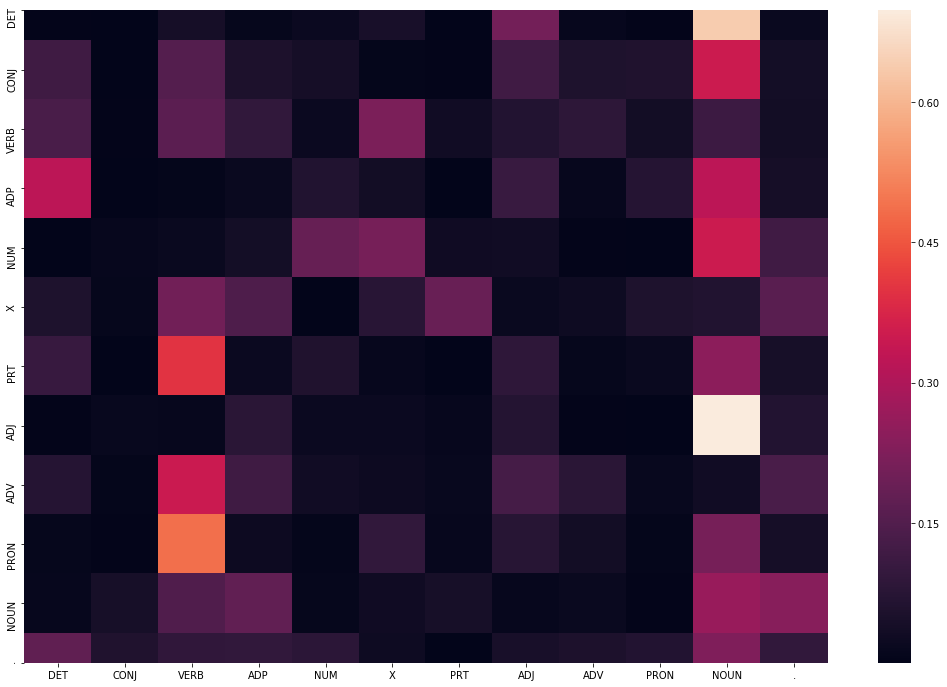

In [152]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [153]:
len(train_tagged_words)

95393

In [154]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

## Evalution on Validation data

In [155]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(validation_set)) for x in range(5)]

# list of sents
validation_run = [validation_set[i] for i in rndom]

# list of tagged words
validation_run_base = [tup for sent in validation_run for tup in sent]

# list of untagged words
validation_tagged_words = [tup[0] for sent in validation_run for tup in sent]
validation_run

[[('The', 'DET'),
  ('Big', 'NOUN'),
  ('Three', 'NOUN'),
  ('auto', 'NOUN'),
  ('makers', 'NOUN'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('the', 'DET'),
  ('rule', 'NOUN'),
  ('changes', 'NOUN'),
  ('were', 'VERB'),
  ("n't", 'ADV'),
  ('surprising', 'ADJ'),
  ('because', 'ADP'),
  ('Bush', 'NOUN'),
  ('administration', 'NOUN'),
  ('officials', 'NOUN'),
  ('have', 'VERB'),
  ('long', 'ADV'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('they', 'PRON'),
  ('planned', 'VERB'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('impose', 'VERB'),
  ('car', 'NOUN'),
  ('safety', 'NOUN'),
  ('standards', 'NOUN'),
  ('on', 'ADP'),
  ('light', 'ADJ'),
  ('trucks', 'NOUN'),
  ('and', 'CONJ'),
  ('vans', 'NOUN'),
  ('.', '.')],
 [('``', '.'),
  ('An', 'DET'),
  ('active', 'ADJ'),
  ('55-year-old', 'NOUN'),
  ('in', 'ADP'),
  ('Boca', 'NOUN'),
  ('Raton', 'NOUN'),
  ('may', 'VERB'),
  ('care', 'VERB'),
  ('more', 'ADV'),
  ('about', 'ADP'),
  ('Senior', 'NOUN'),
  ('Olympic', 'NOUN'),
  ('games', 'NOUN'),
  (',', '.'),

In [156]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(validation_tagged_words)
end = time.time()
difference = end-start

In [157]:
print("Time taken in seconds: ", difference)
print(tagged_seq)


Time taken in seconds:  22.762714385986328
[('The', 'DET'), ('Big', 'NOUN'), ('Three', 'NUM'), ('auto', 'NOUN'), ('makers', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('the', 'DET'), ('rule', 'NOUN'), ('changes', 'NOUN'), ('were', 'VERB'), ("n't", 'ADV'), ('surprising', 'ADJ'), ('because', 'ADP'), ('Bush', 'NOUN'), ('administration', 'NOUN'), ('officials', 'NOUN'), ('have', 'VERB'), ('long', 'ADV'), ('said', 'VERB'), ('0', 'X'), ('they', 'PRON'), ('planned', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('impose', 'VERB'), ('car', 'NOUN'), ('safety', 'NOUN'), ('standards', 'NOUN'), ('on', 'ADP'), ('light', 'ADJ'), ('trucks', 'NOUN'), ('and', 'CONJ'), ('vans', 'NOUN'), ('.', '.'), ('``', '.'), ('An', 'DET'), ('active', 'ADJ'), ('55-year-old', 'DET'), ('in', 'ADP'), ('Boca', 'NOUN'), ('Raton', 'NOUN'), ('may', 'VERB'), ('care', 'VERB'), ('more', 'ADV'), ('about', 'ADP'), ('Senior', 'DET'), ('Olympic', 'NOUN'), ('games', 'NOUN'), (',', '.'), ('while', 'ADP'), ('a', 'DET'), ('75-year-old', 'DET'), ('i

In [158]:
# accuracy
check = [i for i, j in zip(tagged_seq, validation_run_base) if i == j] 

In [159]:
accuracy = len(check)/len(tagged_seq)
accuracy

0.9112903225806451

In [160]:
incorrect_tagged_cases = [[validation_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, validation_run_base)) if j[0]!=j[1]]

In [161]:
incorrect_tagged_cases

[[('Big', 'NOUN'), (('Three', 'NUM'), ('Three', 'NOUN'))],
 [('active', 'ADJ'), (('55-year-old', 'DET'), ('55-year-old', 'NOUN'))],
 [('about', 'ADP'), (('Senior', 'DET'), ('Senior', 'NOUN'))],
 [('a', 'DET'), (('75-year-old', 'DET'), ('75-year-old', 'NUM'))],
 [('.', '.'), (('ORTEGA', 'DET'), ('ORTEGA', 'NOUN'))],
 [('ORTEGA', 'NOUN'), (('ENDED', 'DET'), ('ENDED', 'VERB'))],
 [('two', 'NUM'), (('round-trip', 'DET'), ('round-trip', 'ADJ'))],
 [('on', 'ADP'), (('Trans', 'DET'), ('Trans', 'NOUN'))],
 [('So', 'ADV'), (('Long', 'NOUN'), ('Long', 'ADJ'))],
 [(',', '.'), (('L.A.', 'DET'), ('L.A.', 'NOUN'))],
 [('final', 'ADJ'), (('headline', 'DET'), ('headline', 'NOUN'))]]

In [162]:
for word in incorrect_tagged_cases:
    for x in word:
        print(x[0])
        if(x[0] not in V):
            print("true")

Big
('Three', 'NUM')
true
active
('55-year-old', 'DET')
true
about
('Senior', 'DET')
true
a
('75-year-old', 'DET')
true
.
('ORTEGA', 'DET')
true
ORTEGA
true
('ENDED', 'DET')
true
two
('round-trip', 'DET')
true
on
('Trans', 'DET')
true
So
('Long', 'NOUN')
true
,
('L.A.', 'DET')
true
final
('headline', 'DET')
true


In [163]:
from collections import Counter
tag_counts = Counter(T)
tag_counts

Counter({'DET': 1,
         'CONJ': 1,
         'VERB': 1,
         'ADP': 1,
         'NUM': 1,
         'X': 1,
         'PRT': 1,
         'ADJ': 1,
         'ADV': 1,
         'PRON': 1,
         'NOUN': 1,
         '.': 1})

In [164]:
tag_counts.most_common(5)

[('DET', 1), ('CONJ', 1), ('VERB', 1), ('ADP', 1), ('NUM', 1)]

### Solve the problem of unknown words Method 1

In [165]:
# use transition probability of tags when emission probability is zero(i.e when the word is unkown and not present in the corpus then we can remove emission probability and consider only transition probability.)

def Viterbi_modify1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        prob_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            prob_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        # if probability is zero then use transition probability
        if(pmax==0):
            pmax = max(prob_transition)
            state_max = T[prob_transition.index(pmax)]
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [166]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_modify1(validation_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, validation_run_base) if i == j] 
accuracy1 = len(check)/len(tagged_seq)
print('Modified Viterbi_modify1 Accuracy: ',accuracy*100)

Time taken in seconds:  21.146143198013306
Modified Viterbi_modify1 Accuracy:  91.12903225806451


In [167]:
incorrect_tagged_cases = [[validation_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, validation_run_base)) if j[0]!=j[1]]


In [168]:
incorrect_tagged_cases

[[('Big', 'NOUN'), (('Three', 'NUM'), ('Three', 'NOUN'))],
 [('about', 'ADP'), (('Senior', 'DET'), ('Senior', 'NOUN'))],
 [('a', 'DET'), (('75-year-old', 'NOUN'), ('75-year-old', 'NUM'))],
 [('ORTEGA', 'NOUN'), (('ENDED', 'NOUN'), ('ENDED', 'VERB'))],
 [('two', 'NUM'), (('round-trip', 'NOUN'), ('round-trip', 'ADJ'))],
 [('on', 'ADP'), (('Trans', 'DET'), ('Trans', 'NOUN'))],
 [('So', 'ADV'), (('Long', 'NOUN'), ('Long', 'ADJ'))]]

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [169]:
accuracy

0.9112903225806451

In [170]:
accuracy1

0.9435483870967742

### Solve the problem of unknown words Method 2

In [171]:
# lets create a list containing tuples of POS tags and POS tag occurance probability, based on training data
tag_prob = []
total_tag = len([tag for word,tag in train_tagged_words])
for t in tags:
    each_tag = [tag for word,tag in train_tagged_words if tag==t]
    tag_prob.append((t,len(each_tag)/total_tag))

tag_prob

[('DET', 0.08663109452475548),
 ('CONJ', 0.02246496074135419),
 ('VERB', 0.13443334416571445),
 ('ADP', 0.09764867443103792),
 ('NUM', 0.03510739781744992),
 ('X', 0.06567567850890527),
 ('PRT', 0.03214072311385532),
 ('ADJ', 0.06360005451133731),
 ('ADV', 0.031585126791273996),
 ('PRON', 0.027150839160106088),
 ('NOUN', 0.2873271623704045),
 ('.', 0.11623494386380552)]

In [184]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb    
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*ould$', 'MD'),              # modals
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                   # nouns
]
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

In [185]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

In [186]:
# Modification in Viterbi Algorithm : Backoff to rule based tagger in case unknown word is encountered.
def Viterbi_modify2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        state_max = rule_based_tagger.tag([word])[0][1]       
       
        
        if(pmax==0):
            state_max = rule_based_tagger.tag([word])[0][1] # assign based on rule based tagger
        else:
            if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)]                
            
        
        state.append(state_max)
    return list(zip(words, state))

In [187]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_modify2(validation_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  26.9871027469635


In [188]:
# accuracy
check = [i for i, j in zip(tagged_seq, validation_run_base) if i == j] 
accuracy2 = len(check)/len(tagged_seq)
print('Modified Viterbi_2 Accuracy: ',accuracy2*100)

Modified Viterbi_2 Accuracy:  95.96774193548387


## Using Test Case

In [189]:
file1 = open('Test_sentences.txt')

In [190]:
text = file1.read()
test_sent = text.splitlines()

In [191]:
#list of untagged words
test_words = [word for sent in test_sent for word in sent.split()]

In [192]:
# tagging the test sentences
start = time.time()
sample_tagged_seq = Viterbi(test_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  30.730204343795776


In [193]:
# tagging the test sentences
start = time.time()
sample_tagged_seq = Viterbi_modify2(test_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  27.70608949661255


In [194]:
# let's check the incorrectly tagged words
[j for i, j in enumerate(zip(tagged_seq, validation_run_base)) if j[0] != j[1]]

[(('Three', 'NUM'), ('Three', 'NOUN')),
 (('75-year-old', 'NOUN'), ('75-year-old', 'NUM')),
 (('ENDED', 'NOUN'), ('ENDED', 'VERB')),
 (('round-trip', 'NOUN'), ('round-trip', 'ADJ')),
 (('Long', 'NOUN'), ('Long', 'ADJ'))]

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [195]:
# . is tagged .
# sudden correctly tagged as ADJ
# several correctly tagged as ADJ
# take correctly tagged as VERB